# Finding Word Vectors using TruncatedSVD

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. TF-IDF <br>
5. Function Definitions<br>
6. Word Vector using Truncated SVD<br>
7. K-Means Clustering on Word Vector<br>
8. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
The objective of this project is to convert the Amazon Fine Food Reviews data to word vectors using Truncated SVD and then cluster similar words together by K-Means clustering.<br>
<br>

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

## 3. Loading the Data:

In [2]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [3]:
data.shape

(364171, 12)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [5]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [8]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


## 4. TFIDF:

In [9]:
# applying tf-idf vectorization 
tf_idf_vect = TfidfVectorizer(min_df = 0, max_features = 10000)

In [10]:
#fit&transform the whole data to the tfidf vectorizer
tfidf_model = tf_idf_vect.fit_transform(sorted_data['CleanedText'].values)

In [11]:
type(tfidf_model)

scipy.sparse.csr.csr_matrix

In [12]:
#get the feature names(words here)
feature_array = np.array(tf_idf_vect.get_feature_names())

In [13]:
feature_array.shape

(10000,)

In [14]:
feature_array = feature_array.tolist()

## 5. Function Definitions:

In [15]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [17]:
from tqdm import tqdm

def co_occur_matx():
    window = 5
    co_matx = np.zeros((10000, 10000))
    for sent in tqdm(list_of_sent):
        for i, word in enumerate(sent):
            if word in feature_array:
                for l in range(max(i - window, 0), min(i + window, len(sent))):
                    if sent[l] in feature_array:
                        co_matx[feature_array.index(word), feature_array.index(sent[l])] += 1
    
    return co_matx

In [18]:
from sklearn.cluster import KMeans

# clustering similar words 
def kmean_cluster(data):
    
    fit_models = []
    num_clusters = np.arange(10, 301, 5)
                
    for i in tqdm(num_clusters):
        clf = KMeans(n_clusters = i, n_init = 8) 
        clf.fit(data)
        fit_models.append(clf)

    return fit_models

In [19]:
# find best fit k for kmeans clustering
def find_best_k(clusters):
    
    num_clusts = np.arange(10, 301, 5)
    intra_clust_dists = []
    for clust in clusters:
        intra_clust_dists.append(clust.inertia_)
    sns.set()
    plt.figure(figsize = (8, 5))
    plt.plot(num_clusts, intra_clust_dists, color = 'b')
    plt.xlabel('Num of Clusters')
    plt.ylabel('Intra-Cluster Distances')
    plt.title('Intra-Cluster Distance Vs Num of Clusters')
    plt.plot()

## 6. Word Vectors using Truncated SVD:

In [20]:
comatx = co_occur_matx()

100%|██████████| 364171/364171 [3:50:24<00:00, 26.34it/s]  


In [21]:
#set the diagonal of co-occurrence matrix to 0
np.fill_diagonal(comatx, 0)

In [22]:
def var_explained_n(matrix):
    var_exp = []
    for i in tqdm(np.arange(1, 501, 20)):
        svd_model = TruncatedSVD(n_components = i)
        svd_model.fit(matrix)
        var_exp.append(svd_model.explained_variance_ratio_.sum())
    
    return var_exp 

In [208]:
def variance_cumsum(variance_list):
    sns.set()
    n_component = np.arange(1, 501, 20)
    plt.figure(figsize=(8, 5))
    plt.plot(n_component, variance_list, color = 'g')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Sum of Variance Ratio')
    plt.title('Best-fit n_componets for T-SVD')

In [24]:
var_explained = var_explained_n(comatx)

100%|██████████| 25/25 [02:03<00:00,  8.53s/it]


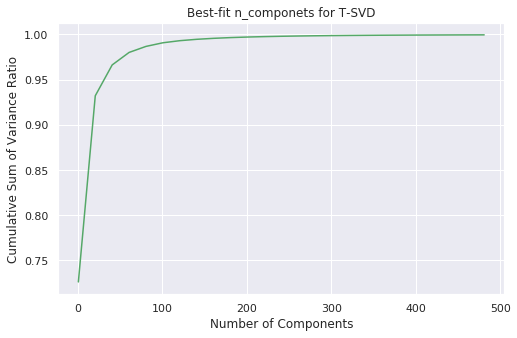

In [209]:
variance_cumsum(var_explained)

In [26]:
svd_model = TruncatedSVD(n_components = 250)
w_vec = svd_model.fit_transform(comatx)

In [27]:
w_vec.shape

(10000, 250)

In [28]:
svd_model.explained_variance_ratio_.sum()

0.9981429514308281

## 7. K-Means Clustering on Word Vector

In [29]:
word_clusters = kmean_cluster(w_vec)

100%|██████████| 59/59 [06:08<00:00, 13.55s/it]


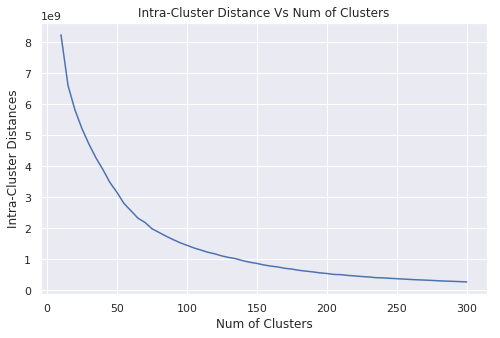

In [30]:
# find best k from the plot
find_best_k(word_clusters)

#### Observation:
* From this curve it seems after 150 clusters the slope of the curve decreases. So, I'm taking 150 as the best-fit K.

In [31]:
cluster150 = word_clusters[28]

In [32]:
cluster_sizes = []
for i in range(0, 150):
    cluster_sizes.append(len(np.array(feature_array)[cluster150.labels_ == i]))

In [65]:
def find_cosine_similarity(vec0, vec1):

    similarity = np.dot(vec0, vec1.T) / (np.linalg.norm(vec0) * np.linalg.norm(vec1))
    return similarity

In [147]:
from wordcloud import WordCloud

def find_related_words(word):
    cluster_indx = 0
    
    for i in range(0, 150):
        if word in np.array(feature_array)[cluster150.labels_ == i]:
            cluster_no = i
    print('The word "{}" is present in cluster number: {}'.format(word, cluster_no))
    
    word_indx = feature_array.index(word)
    word_vec = w_vec[word_indx, :]
    words_similarity = []
    words_indx_list = []
    
    for words in np.array(feature_array)[cluster150.labels_ == cluster_no]:
        words_indx = feature_array.index(words)
        words_vec = w_vec[words_indx, :]
        words_indx_list.append(words_indx)
        words_similarity.append(find_cosine_similarity(word_vec, words_vec))
    sorted_indx = np.argsort(words_similarity)[::-1]
    
    sorted_words_indx = []
    for indx in sorted_indx:
        sorted_words_indx.append(words_indx_list[indx])
    
    most_similar_words = []
    for imp_word_indx in sorted_words_indx:
        most_similar_words.append(feature_array[imp_word_indx])
    
    print('Most Related Words in Word-Cloud\n')
    word_dict = {}
    indx = 0
    for w in most_similar_words:
        word_dict[w] = np.nan_to_num((np.take(words_similarity, sorted_indx)))[indx] * 100000
        indx += 1
                 
    wordcloud = WordCloud(width = 1080, height = 720, 
                background_color ='black',
                min_font_size = 10).fit_words(word_dict)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") 
    plt.tight_layout(pad = 0)
  
    plt.show() 

The word "gastric" is present in cluster number: 0
Most Related Words in Word-Cloud



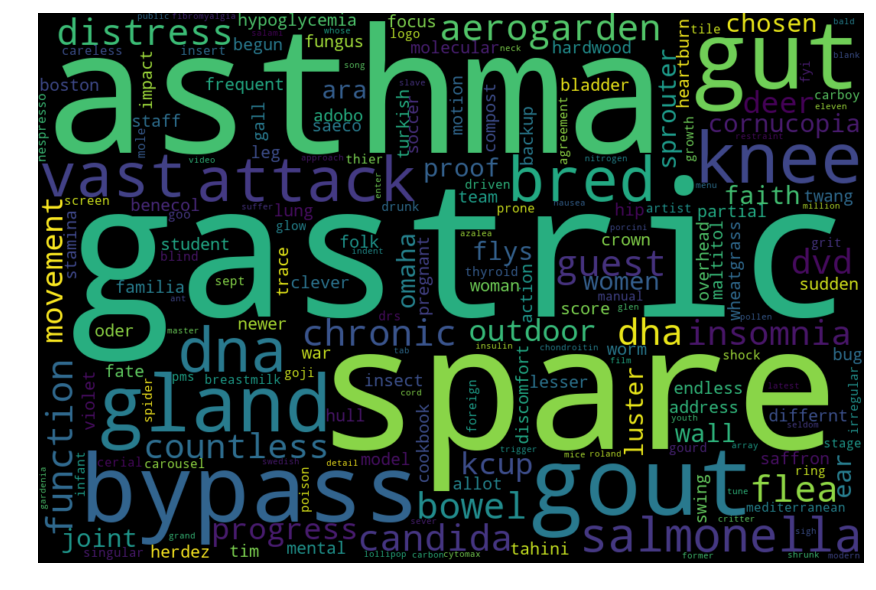

In [180]:
find_related_words('gastric')

#### Observation:
* The word 'gastric' is found to be in cluster 0 and most similar words to 'gastric' are presented in the word cloud. And these words are about diseases, so this word-cluster gathers various diseases and related words to them. 

The word "taco" is present in cluster number: 45
Most Related Words in Word-Cloud



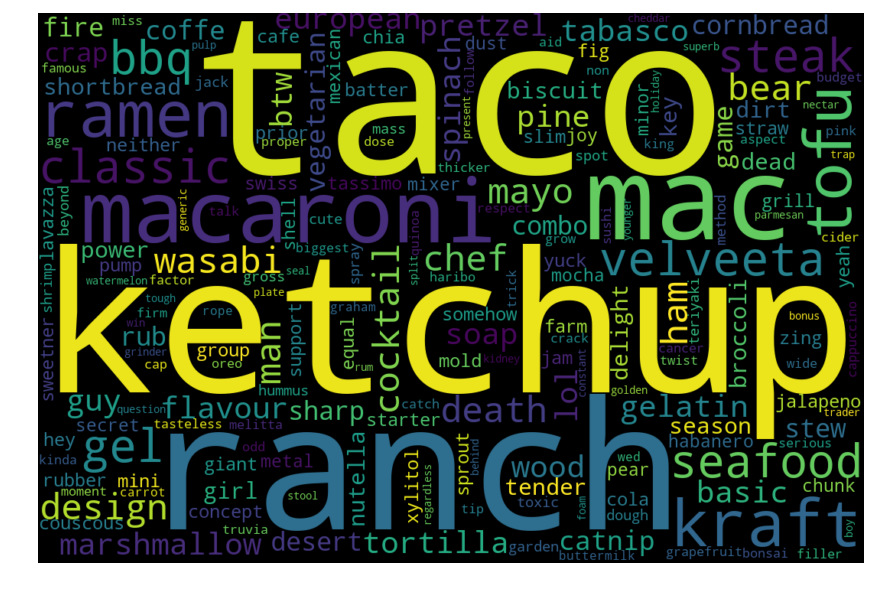

In [114]:
find_related_words('taco')

#### Observation:
* The word 'taco' is found to be in cluster 45 and most similar words to 'taco' are presented in the word cloud above. These words are related to 'taco' which is a maxican dist and related words to this dish are macaroni, mayo, ketchup, tortilla etc. Even It managed to cluster similar items related to dishes like chef, bbq, fire etc 

The word "america" is present in cluster number: 87
Most Related Words in Word-Cloud



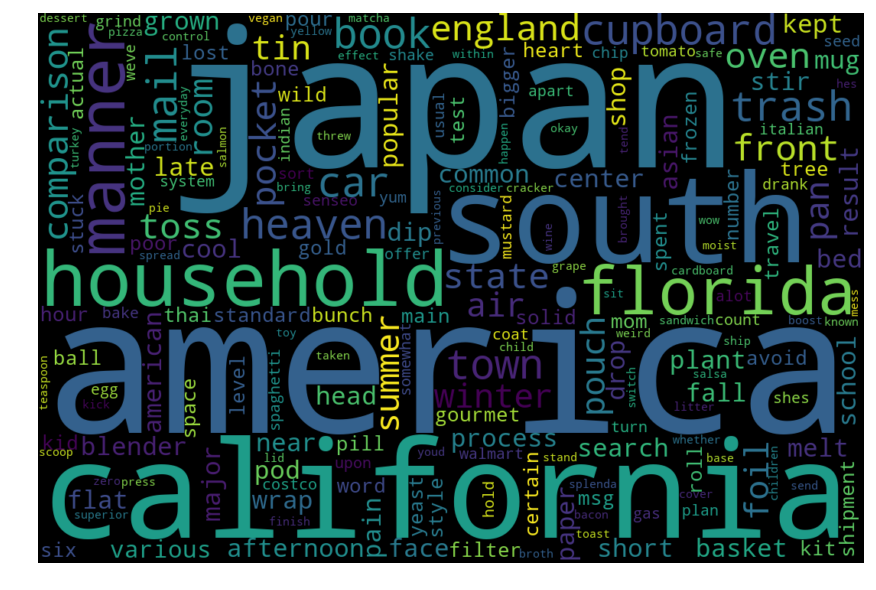

In [129]:
find_related_words('america')

#### Observation:
* The word 'america' is found to be in cluster 87 and most similar words to 'america' are presented above in the word cloud. And these words related to country names like england, japan and states within america like california, florida etc.

The word "star" is present in cluster number: 88
Most Related Words in Word-Cloud



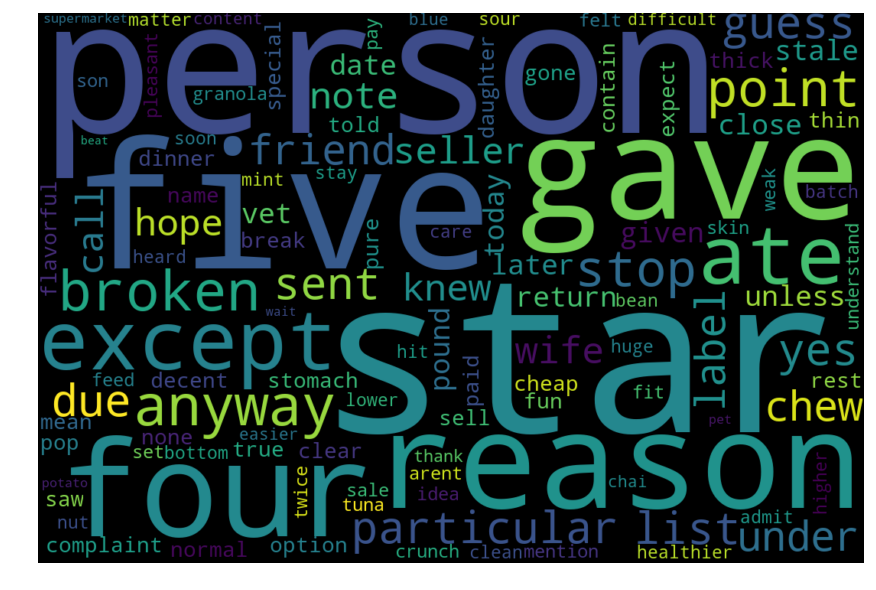

In [197]:
find_related_words('star')

#### Observation:
* The word 'star' is found to be in cluster 88 and most similar words to 'star' are presented in this word cloud. And these words are about star rating like five star, four star and products related to that rating.

The word "clove" is present in cluster number: 0
Most Related Words in Word-Cloud



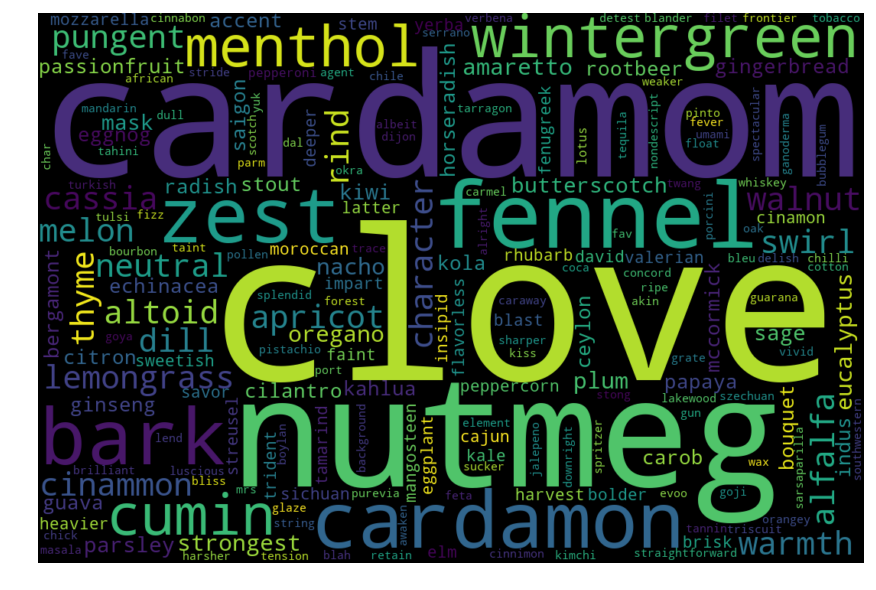

In [174]:
find_related_words('clove')

#### Observation:
* The word 'clove' is found to be in cluster 0 and most similar words to 'clove' are presented in the word cloud. As 'clove' comes under spices so, the cluster gathers all spices names from the cluster. 

## 8. Summary 

#### Approach:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  The Amazon Fine Food dataset is used here to cluster them in some groups. I have taken only 10000 top words from TFIDF representation as calculating co-occurrence matrix takes much time. I used Truncated SVD to find word vector representation and applied K-Means clustering to it to cluster similar words together. Then I selected random words and found out to which cluster they belong and most related words to them in that cluster using cosine similarity.
<br>
#### Conclusion:
* Both Truncated SVD and K-Means clustering performed well as the final clusters are very much meaningful. 